In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from datetime import timedelta, date, datetime
from sqlalchemy.types import NVARCHAR, DATE, FLOAT, VARCHAR, DATETIME
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, confusion_matrix, plot_roc_curve,\
    plot_confusion_matrix, recall_score, precision_score, accuracy_score

from sklearn.preprocessing import StandardScaler
from helpers import *

data_dir = "../data"

sns.set_style('whitegrid')


## Feature extraction

In [115]:
from sqlalchemy import create_engine
import pandas as pd
import config
from sql_queries import *

engine = create_engine(
    f"mysql+pymysql://{config.sql_credentials['user']}:{config.sql_credentials['password']}@{config.sql_credentials['host']}:{config.sql_credentials['port']}/{config.sql_credentials['db']}",
    pool_pre_ping=True)

conn = engine.connect()
#
# print(datetime.now())
# login_data = pd.read_sql(login_query, conn)
# print(datetime.now())
# dist_data = pd.read_sql(dist_query, conn)
# print(datetime.now())
# prefs_data = pd.read_sql(prefs_query, conn)
# print(datetime.now())
# training_data = pd.read_sql(training_query, conn)
# print(datetime.now())
# worked_data = pd.read_sql(worked_query, conn)
# print(datetime.now())
# days_worked_data = pd.read_sql(days_worked_query,conn)
# print(datetime.now())
# apps_done_data = pd.read_sql(apps_done_query,conn)
# print(datetime.now())
# logs_done_data = pd.read_sql(logs_done_query,conn)
# print(datetime.now())
# print(datetime.now())
# texts_received_data = pd.read_sql(texts_received_query, conn)
# print(datetime.now())
# login_events_data = pd.read_sql(logins_events_query, conn)
# print(datetime.now())
# views_done_data = pd.read_sql(views_done_query, conn)
# print(datetime.now())
# pvs_data = pd.read_sql(pvs_query, conn)
# print(datetime.now())
# md_data = pd.read_sql(md_query, conn)
# print(datetime.now())
#
# md_data.to_csv('../data/md_data.csv', index = False)#
# pvs_data.to_csv('../data/pvs_data.csv', index = False)
# views_done_data.to_csv('../data/views_done_data.csv', index = False)
# login_events_data.to_csv('../data/login_events_data.csv', index = False)
# days_worked_data.to_csv('../data/days_worked_data.csv', index = False)
# logs_done_data.to_csv('../data/logs_done_data.csv', index = False)
# apps_done_data.to_csv('../data/apps_done_data.csv', index = False)
# login_data.to_csv('../data/login_data.csv', index = False)
# dist_data.to_csv('../data/dist_data.csv', index = False)
# worked_data.to_csv('../data/worked_data.csv', index = False)
# prefs_data.to_csv('../data/prefs_data_v2.csv', index = False)
# training_data.to_csv('../data/training_data_v2.csv', index = False)
# texts_received_data.to_csv('../data/texts_received_data.csv', index = False)


2021-09-14 12:03:02.591112
2021-09-14 12:04:43.181715


## Feature engineering

In [78]:
login_data = pd.read_csv('../data/login_data.csv')
dist_data = pd.read_csv('../data/dist_data.csv')
worked_data = pd.read_csv('../data/worked_data.csv')
prefs_data = pd.read_csv('../data/prefs_data_v2.csv')
training_data = pd.read_csv('../data/training_data_v2.csv')
days_worked_data = pd.read_csv('../data/days_worked_data.csv')
apps_done_data = pd.read_csv('../data/apps_done_data.csv')
logs_done_data = pd.read_csv('../data/logs_done_data.csv')
texts_received_data = pd.read_csv('../data/texts_received_data.csv')
# logins_events_data = pd.read_csv('../data/login_events_data.csv')
views_done_data = pd.read_csv('../data/views_done_data.csv')
pvs_data = pd.read_csv('../data/pvs_data.csv')
md_data = pd.read_csv('../data/md_data.csv')

In [119]:
days_worked_data['date'] = days_worked_data.date.apply(lambda x:str(x))
logs_done_data['date'] = logs_done_data.date.apply(lambda x:str(x))
texts_received_data['date'] = texts_received_data.date.apply(lambda x:str(x))
apps_done_data['date'] = apps_done_data.date.apply(lambda x:str(x))
views_done_data['date'] = views_done_data.date.apply(lambda x:str(x))
pvs_data['sent_at'] = pvs_data['sent_at'].apply(lambda x:str(x))
md_data['sent_at'] = md_data['sent_at'].apply(lambda x:str(x))

training_data['date_sent_at'] = pd.to_datetime(training_data['sent_at'],format='%Y-%m-%d').dt.date.apply(lambda x:str(x))

print(training_data.shape)
all_data = training_data.merge(login_data, how='left', on = ['placement_ad_id','carer_id','sent_at'])
print(all_data.shape)
all_data = all_data.merge(prefs_data, how='left', on = ['placement_ad_id','carer_id','sent_at'])
print(all_data.shape)
all_data = all_data.merge(dist_data, how='left', on = ['placement_ad_id','carer_id','sent_at'])
print(all_data.shape)
all_data = all_data.merge(worked_data, how='left', on = ['placement_ad_id','carer_id','sent_at'])
print(all_data.shape)
all_data = all_data.merge(days_worked_data, how='left', left_on = ['date_sent_at','carer_id'],
                          right_on = ['date','carer_id'])
print(all_data.shape)
all_data = all_data.merge(apps_done_data, how='left', left_on = ['date_sent_at','carer_id'],
                          right_on = ['date','carer_id'])
print(all_data.shape)
all_data.drop(['date_x','date_y'],axis=1, inplace = True)
print(all_data.shape)
all_data = all_data.merge(logs_done_data, how='left', left_on = ['date_sent_at','carer_id'],
                          right_on = ['date','carer_id'])
print(all_data.shape)
all_data = all_data.merge(texts_received_data, how='left', left_on = ['date_sent_at','carer_id'],
                          right_on = ['date','carer_id'])
print(all_data.shape)
all_data = all_data.merge(views_done_data, how='left', left_on = ['date_sent_at','carer_id'],
                          right_on = ['date','carer_id'])
print(all_data.shape)
all_data = all_data.merge(pvs_data, how='left', left_on = ['sent_at','carer_id'],
                          right_on = ['sent_at','carer_id'])
print(all_data.shape)
all_data = all_data.merge(md_data, how='left', on = ['placement_ad_id','carer_id','sent_at'])
print(all_data.shape)

all_data.drop_duplicates(subset=['placement_ad_id','carer_id','sent_at'], inplace = True)
print(all_data.shape)


target = 'carer_applied_in_8hrs'

(2246563, 38)
(2246563, 39)
(2246563, 69)
(2246563, 70)
(2246563, 73)
(2246563, 75)
(2246563, 77)
(2246563, 75)
(2246563, 77)
(2246563, 79)
(2246563, 81)
(2246563, 82)
(2246563, 83)
(1963934, 83)


In [190]:
print(f'There are {all_data[target].sum()} applications for {all_data.placement_ad_id.nunique()} placement ads')

There have been 17072 applications for 15000 placement ads


In [227]:
all_data.groupby('sms_type')[target].sum()/all_data.groupby('sms_type')[target].count()* 100

sms_type
customListSent            0.647119
initialPromotionSent      2.011581
preferredPlacementSent    1.707971
returningCarerSent        0.810026
slowMatchingSent          1.163568
urgentMatchSent           0.780866
Name: carer_applied_in_8hrs, dtype: float64

In [460]:
target = 'carer_applied_in_8hrs'

X1 = all_data.loc[all_data['carer_applied_in_8hrs']==1]
X0 = all_data.loc[all_data['carer_applied_in_8hrs']==0].sample(frac=0.5, random_state=1992)

df = pd.concat([X1,X0], axis = 0)
df


,placement_ad_id,match_request_id,carer_id,sent_at,updated_at,sms_type,carer_applied_in_8hrs,lead_time,ongoing,min_provider_rate,...,days_worked_past_90,apps_past_7_days,date_x,login_past_7_days,date_y,texts_past_30_days,date,viewed_placements_past_7_days,predicted_value,difficulty_normalised
19,plad_pl_s062kkx0J0QL_j4cB-d1dabaa0-acbb-4dc1-9...,pl_s062kkx0J0QL_j4cB-d1dabaa0-acbb-4dc1-9754-c...,p100093502,2021-08-17 11:29:26,2021-08-17 11:28:26,initialPromotionSent,1,34,1,700.0,...,7.0,3.0,2021-08-17,43.0,2021-08-17,83.0,2021-08-17,5.0,NaN,NaN
27,plad_pl_s01HFZJkHmIL_4BaD-19e7269b-1f1e-4281-a...,pl_s01HFZJkHmIL_4BaD-19e7269b-1f1e-4281-a4c1-2...,p100139148,2019-12-30 11:44:46,2019-12-30 11:36:45,initialPromotionSent,1,7,0,550.0,...,25.0,21.0,2019-12-30,45.0,2019-12-30,53.0,NaN,NaN,NaN,0.568004
82,plad_pl_s0SmL39RWSVK_buQY-7a0c3a05-036b-453c-8...,pl_s0SmL39RWSVK_buQY-7a0c3a05-036b-453c-8ed6-8...,p100139148,2020-02-07 16:44:36,2020-02-07 16:36:02,initialPromotionSent,1,4,1,550.0,...,29.0,NaN,2020-02-07,15.0,2020-02-07,97.0,NaN,NaN,NaN,1.604750
149,plad_pl_s0cCuetHrFmd_00QZ-dd9a0882-3ea3-4362-8...,pl_s0cCuetHrFmd_00QZ-dd9a0882-3ea3-4362-8c3c-a...,p100146905,2021-07-02 16:17:30,2021-07-02 16:08:38,initialPromotionSent,1,5,0,600.0,...,NaN,NaN,NaN,NaN,2021-07-02,100.0,NaN,NaN,139.8040,1.705170
430,plad_pl_s063CSCZAYUm_4jbo-e89250f1-628c-4d24-a...,pl_s063CSCZAYUm_4jbo-e89250f1-628c-4d24-a59b-a...,p100481747,2020-08-17 11:45:35,2020-08-17 11:28:30,initialPromotionSent,1,7,1,650.0,...,NaN,1.0,2020-08-17,17.0,2020-08-17,23.0,NaN,NaN,84.1962,1.270840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1517834,plad_pl_s0ISwuCFea2v_JUaT-2e38bbae-d0ac-43e0-8...,pl_s0ISwuCFea2v_JUaT-2e38bbae-d0ac-43e0-812c-d...,p209391800,2020-12-05 11:15:17,2020-12-05 11:14:11,customListSent,0,3,0,560.0,...,NaN,NaN,2020-12-05,5.0,2020-12-05,5.0,NaN,NaN,177.1070,1.561150
706159,plad_pl_s0FmpKVRVcIU_LWuZ-45855f23-d118-4975-b...,pl_s0FmpKVRVcIU_LWuZ-45855f23-d118-4975-b6d4-5...,p210732857,2021-01-05 09:40:36,2021-01-05 09:36:18,urgentMatchSent,0,1,1,560.0,...,NaN,NaN,NaN,NaN,2021-01-05,53.0,NaN,NaN,114.9060,0.602581
524579,plad_pl_s0JYa1kTlRN7_YQKs-19a534b2-ae70-4dc6-a...,pl_s0JYa1kTlRN7_YQKs-19a534b2-ae70-4dc6-a81a-9...,p9428478,2021-05-19 15:42:12,2021-05-18 17:27:01,slowMatchingSent,0,34,1,560.0,...,76.0,NaN,2021-05-19,4.0,2021-05-19,4.0,NaN,NaN,83.6292,1.608980
919235,plad_pl_s0JekZw25WGu_uh6j-c0a3ffaf-f9ba-4be3-a...,pl_s0JekZw25WGu_uh6j-c0a3ffaf-f9ba-4be3-a03c-7...,p97722900,2020-06-19 14:10:37,2020-06-19 14:08:14,urgentMatchSent,0,1,0,600.0,...,NaN,NaN,NaN,NaN,2020-06-19,16.0,NaN,NaN,NaN,1.739740


In [461]:
predictors = df.columns.tolist()

[predictors.remove(x) for x in [target,
'match_request_id',
'carer_id',
'sent_at',
'updated_at',
'set_at',
'latitude',
'longitude',
'start_date_time',
'date',
'date_x',
'date_y',
'date_sent_at',
'carer_logged_in_7_days',
'texts_past_30_days',
'carer_worked_in_30_days',
'predicted_value'] if x in predictors]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [462]:
df['texts_past_30_days'].replace(np.nan,0,inplace = True)
df['login_past_7_days'].replace(np.nan,0,inplace = True)
df['apps_past_7_days'].replace(np.nan,0,inplace = True)
df['days_worked_past_90'].replace(np.nan,0,inplace = True)
df['carer_worked_in_7_days'].replace(np.nan,0,inplace = True)
df['carer_worked_in_30_days'].replace(np.nan,0,inplace = True)
df['carer_logged_in_7_days'].replace(np.nan,0,inplace = True)
df['viewed_placements_past_7_days'].replace(np.nan,0,inplace = True)


df = pd.get_dummies(df,columns=['sms_type'],drop_first=True)

df['max_cr_age']= df['max_cr_age'].clip(18,118)

df['log_lead_time'] = np.log(np.where(df['lead_time']>0,df['lead_time'],0.01))
df['exp_lead_time'] = np.exp(np.where(df['lead_time']>0,df['lead_time'],0.01))
df['log_lead_time'] = df.log_lead_time.clip(0)

#carer likes X and X is there
df['met_licence'] = df['has_licence'] * df['licence_needed']
df['met_car'] = df['has_car'] * df['car_needed']

df['met_moving_handling'] = df['moving_handling'] * df['carer_moving_handling']
df['met_stoma'] = df['stoma'] * df['carer_stoma']
df['met_dementia'] = df['dementia'] * df['carer_dementia']
df['met_alzheimers'] = df['alzheimers'] * df['carer_alzheimers']
df['met_parkinsons'] = df['parkinsons'] * df['carer_parkinsons']
df['met_stroke'] = df['stroke'] * df['carer_stroke']
df['met_diabetes'] = df['diabetes'] * df['carer_diabetes']
df['met_peg'] = df['peg'] * df['carer_peg']
df['met_hoist'] = df['hoist'] * df['carer_hoist']
df['met_mental_health_issue'] = df['mental_health_issues'] * df['carer_mental_health_issues']

df['met_distance_50'] = np.where((df['maxDistance_50']==1) & (df['distance_km']*1.61 <= 50),1,0 )
df['met_distance_100'] = np.where((df['maxDistance_100']==1) & (df['distance_km']*1.61 <= 100),1,0 )
df['met_distance_400'] = np.where((df['maxDistance_400']==1) & (df['distance_km']*1.61 <= 400),1,0 )

#carer doesn't like X and X is not there
df['met_smoking'] = np.where((df['smoking'] == 0 )& (df['smokingClientsExclusion'] ==1),1,0)
df['met_dogs'] = np.where((df['has_dogs'] == 0) & (df['petsExclusion_DOGS'] ==1),1,0)
df['met_cats'] = np.where((df['has_cats'] == 0 )& (df['petsExclusion_CATS'] ==1),1,0)
df['met_2crs'] = np.where((df['has_two_crs'] == 0) & (df['recipientNumberExclusion_2CRs'] ==1),1,0)
df['met_cr_gender'] = np.where((df['recipient_1_male'] == 0) & (df['genderExclusion_MALE'] ==1),1,0)


df['met_ear_WHITE_ALL'] = np.where((df['ethnicities_at_risk_WHITE_ALL'] ==0) & (df['ethnicityExclusion_WHITE_ALL'] ==1),1,0)
df['met_ear_MIXED_ALL'] = np.where((df['ethnicities_at_risk_MIXED_ALL'] ==0) & (df['ethnicityExclusion_MIXED_ALL'] ==1),1,0)
df['met_ear_BLACK_ALL'] = np.where((df['ethnicities_at_risk_BLACK_ALL'] ==0) & (df['ethnicityExclusion_BLACK_ALL'] ==1),1,0)
df['met_ear_ASIAN_ALL'] = np.where((df['ethnicities_at_risk_ASIAN_ALL'] ==0) & (df['ethnicityExclusion_ASIAN_ALL'] ==1),1,0)
df['met_ear_ARAB_ALL'] = np.where((df['ethnicities_at_risk_ARAB_ALL'] ==0) & (df['ethnicityExclusion_ARAB_ALL'] ==1),1,0)

#carer doesn't like X but X is there
df['broken_ear_WHITE_ALL'] = df['ethnicities_at_risk_WHITE_ALL'] * df['ethnicityExclusion_WHITE_ALL']
df['broken_ear_MIXED_ALL'] = df['ethnicities_at_risk_MIXED_ALL']* df['ethnicityExclusion_MIXED_ALL']
df['broken_ear_BLACK_ALL'] = df['ethnicities_at_risk_BLACK_ALL'] * df['ethnicityExclusion_BLACK_ALL']
df['broken_ear_ASIAN_ALL'] = df['ethnicities_at_risk_ASIAN_ALL'] * df['ethnicityExclusion_ASIAN_ALL']
df['broken_ear_ARAB_ALL'] = df['ethnicityExclusion_ARAB_ALL'] * df['ethnicityExclusion_ARAB_ALL']


## count of soft preferences that are met
df['count_soft_preferences'] = df['met_distance_50'] +  df['met_distance_100'] + df['met_distance_400'] + \
                               df['met_smoking'] + df['met_dogs'] + df['met_cats'] + df['met_2crs'] + \
                               df['met_cr_gender'] + df['met_ear_WHITE_ALL']  + df['met_ear_MIXED_ALL']  + \
                               df['met_ear_BLACK_ALL']  + df['met_ear_ASIAN_ALL'] +df['met_ear_ARAB_ALL']

In [463]:
## interactions of "every" feature with the top three

adj_predictors = predictors
[adj_predictors.remove(x) for x in ['placement_ad_id','apps_past_7_days',
                                    'days_worked_past_90','distance_km','sms_type'] if x in adj_predictors]

for p in adj_predictors:
    # print(p)
    df[f'days_worked_{p}'] = df['days_worked_past_90'] * df[p]
    df[f'apps_past_{p}'] = df['apps_past_7_days'] * df[p]
    df[f'distance_{p}'] = df['distance_km'] * df[p]


In [297]:
df['count_soft_preferences'].value_counts()


0    153617
1     26548
2     10345
3      4820
5      2262
4      2057
6       958
7       269
8        94
9        13
Name: count_soft_preferences, dtype: int64

## Feature selection

In [464]:
predictors = df.columns.tolist()

[predictors.remove(x) for x in [target,
'match_request_id',
'carer_id',
'sent_at',
'updated_at',
'set_at',
'latitude',
'longitude',
'start_date_time',
'date',
'date_x',
'date_y',
'date_sent_at',
'carer_logged_in_7_days',
'texts_past_30_days',
'carer_worked_in_30_days',
'predicted_value'] if x in predictors]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [465]:
for p in predictors:
    if df[p].isna().sum()>0:
        print(p,df[p].isna().sum())

print(df.shape)
df = df.loc[df[predictors].notnull().all(axis=1)]
print(df.shape)

max_cr_age 10548
ethnicityExclusion_ARAB_ALL 6052
ethnicityExclusion_ASIAN_ALL 6052
ethnicityExclusion_BLACK_ALL 6052
ethnicityExclusion_MIXED_ALL 6052
ethnicityExclusion_WHITE_ALL 6052
genderExclusion_MALE 6052
maxDistance_50 6052
maxDistance_100 6052
maxDistance_400 6052
petsExclusion_CATS 6052
petsExclusion_DOGS 6052
recipientNumberExclusion_2CRs 6052
smokingClientsExclusion 6052
has_licence 6052
has_car 6052
carer_moving_handling 6052
carer_dementia 6052
carer_mental_health_issues 6052
carer_hoist 6052
carer_parkinsons 6052
carer_stroke 6052
carer_alzheimers 6052
carer_stoma 6052
carer_diabetes 6052
carer_peg 6052
carer_age 7365
log_career_years_of_experience 29303
log_years_on_elder 8629
carer_gender_FEMALE 6052
distance_km 4508
difficulty_normalised 2409
met_licence 6052
met_car 6052
met_moving_handling 6052
met_stoma 6052
met_dementia 6052
met_alzheimers 6052
met_parkinsons 6052
met_stroke 6052
met_diabetes 6052
met_peg 6052
met_hoist 6052
met_mental_health_issue 6052
broken_ear

In [308]:
# X_train, X_eval, y_train, y_eval = split_train_test(df.sort_values('placement_ad_id'),predictors,target,shuffle = False, test_size=0.25)
#
# print(f'There are {X_train.placement_ad_id.nunique()} placements in the training set with {y_train.sum().values[0]} applications')
# print(f'There are {X_eval.placement_ad_id.nunique()} placements in the eval set with {y_eval.sum().values[0]} applications')
#
# X_train.drop('placement_ad_id', axis = 1, inplace= True)
# X_eval.drop('placement_ad_id', axis = 1, inplace= True)

There are 9602 placements in the training set with 11930 applications
There are 3290 placements in the eval set with 4137 applications


In [466]:
X_train, X_eval, y_train, y_eval = split_train_test(df,predictors,target,test_size=0.25)

print(f'There are {X_train.placement_ad_id.nunique()} placements in the training set with {y_train.sum().values[0]} applications')
print(f'There are {X_eval.placement_ad_id.nunique()} placements in the eval set with {y_eval.sum().values[0]} applications')

X_train.drop('placement_ad_id', axis = 1, inplace= True)
X_eval.drop('placement_ad_id', axis = 1, inplace= True)

There are 13729 placements in the training set with 11980 applications
There are 12978 placements in the eval set with 4087 applications


In [467]:
scaler = StandardScaler()
model = LogisticRegression(max_iter=10000)

scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_eval = pd.DataFrame(scaler.transform(X_eval), index=X_eval.index, columns=X_eval.columns)


In [359]:
n_features = 7
X = X_train
y = np.ravel(y_train)

recall_scorer = make_scorer(recall_score, greater_is_better=True)
precision_scorer = make_scorer(precision_score, greater_is_better=True) #gets zero positive examples in some folds

results = select_features(model, n_features, y, X,scoring=recall_scorer)

Running for 1 features
Selected features: ['distance_one_off_payments_total']
Fit summary: 0.6641792559273251 (0.6451612903225806 to 0.6745635910224439)
Running for 2 features
Selected features: ['days_worked_one_off_payments_total', 'distance_one_off_payments_total']
Fit summary: 0.7163733915388171 (0.709274193548387 to 0.7298420615128844)
Running for 3 features
Selected features: ['carer_diabetes', 'days_worked_one_off_payments_total', 'distance_one_off_payments_total']
Fit summary: 0.7184375274431193 (0.7129032258064516 to 0.7281795511221946)
Running for 4 features
Selected features: ['carer_diabetes', 'days_worked_one_off_payments_total', 'distance_one_off_payments_total', 'distance_recipientNumberExclusion_2CRs']
Fit summary: 0.718505864994115 (0.7146475306036302 to 0.7252701579384871)
Running for 5 features
Selected features: ['carer_diabetes', 'days_worked_one_off_payments_total', 'distance_one_off_payments_total', 'apps_past_peg', 'distance_recipientNumberExclusion_2CRs']
Fit s

In [ ]:
f_predictors = list(set(sum(list(results.loc[results.cv_score == results.cv_score.max()]['features']), [])))

In [ ]:
heat_list = f_predictors + [target]

fig, ax = plt.subplots(1, 2, figsize=(25, 8))

sns.lineplot(x=range(1, n_features), y=results['cv_score'], ax = ax[0], linewidth = 3)
sns.heatmap(training_data[heat_list].corr(), cmap='Blues', annot=True, ax = ax[1])

## Model performance

### Baseline

In [97]:
predictors

['lead_time',
 'ongoing',
 'min_provider_rate',
 'one_off_payments_total',
 'licence_needed',
 'car_needed',
 'moving_handling',
 'dementia',
 'mental_health_issues',
 'hoist',
 'parkinsons',
 'stroke',
 'alzheimers',
 'stoma',
 'diabetes',
 'peg',
 'has_wifi',
 'smoking',
 'has_dogs',
 'has_cats',
 'has_two_crs',
 'max_cr_age',
 'recipient_1_male',
 'ethnicities_at_risk_WHITE_ALL',
 'ethnicities_at_risk_MIXED_ALL',
 'ethnicities_at_risk_BLACK_ALL',
 'ethnicities_at_risk_ASIAN_ALL',
 'ethnicities_at_risk_ARAB_ALL',
 'ethnicityExclusion_ARAB_ALL',
 'ethnicityExclusion_ASIAN_ALL',
 'ethnicityExclusion_BLACK_ALL',
 'ethnicityExclusion_MIXED_ALL',
 'ethnicityExclusion_WHITE_ALL',
 'genderExclusion_MALE',
 'maxDistance_50',
 'maxDistance_100',
 'maxDistance_400',
 'petsExclusion_CATS',
 'petsExclusion_DOGS',
 'recipientNumberExclusion_2CRs',
 'smokingClientsExclusion',
 'has_licence',
 'has_car',
 'carer_moving_handling',
 'carer_dementia',
 'carer_mental_health_issues',
 'carer_hoist',
 'c

In [471]:
 # 'days_worked_past_90',
f_predictors = [
'difficulty_normalised','days_worked_past_90','apps_past_7_days',
    'carer_gender_FEMALE','log_lead_time','distance_km',
    'has_dogs','log_years_on_elder', 'max_cr_age'
]
model.fit(X_train[f_predictors], np.ravel(y_train))


preds = model.predict(X_eval[f_predictors])
pred_probs = model.predict_proba(X_eval[f_predictors])

print(f'Recall is {round(recall_score(y_eval,preds),5)}, accuracy is {round(accuracy_score(y_eval,preds),5)}, precision is {round(precision_score(y_eval,preds),5)}')



Recall is 0.06411, accuracy is 0.98251, precision is 0.47464


In [367]:
X_train.columns.tolist()

['lead_time',
 'ongoing',
 'min_provider_rate',
 'one_off_payments_total',
 'licence_needed',
 'car_needed',
 'moving_handling',
 'dementia',
 'mental_health_issues',
 'hoist',
 'parkinsons',
 'stroke',
 'alzheimers',
 'stoma',
 'diabetes',
 'peg',
 'has_wifi',
 'smoking',
 'has_dogs',
 'has_cats',
 'has_two_crs',
 'max_cr_age',
 'recipient_1_male',
 'ethnicities_at_risk_WHITE_ALL',
 'ethnicities_at_risk_MIXED_ALL',
 'ethnicities_at_risk_BLACK_ALL',
 'ethnicities_at_risk_ASIAN_ALL',
 'ethnicities_at_risk_ARAB_ALL',
 'ethnicityExclusion_ARAB_ALL',
 'ethnicityExclusion_ASIAN_ALL',
 'ethnicityExclusion_BLACK_ALL',
 'ethnicityExclusion_MIXED_ALL',
 'ethnicityExclusion_WHITE_ALL',
 'genderExclusion_MALE',
 'maxDistance_50',
 'maxDistance_100',
 'maxDistance_400',
 'petsExclusion_CATS',
 'petsExclusion_DOGS',
 'recipientNumberExclusion_2CRs',
 'smokingClientsExclusion',
 'has_licence',
 'has_car',
 'carer_moving_handling',
 'carer_dementia',
 'carer_mental_health_issues',
 'carer_hoist',
 'c

In [469]:
ff_predictors = set([
 'apps_past_7_days',
 'apps_past_carer_worked_in_7_days',
 'apps_past_difficulty_normalised',
 'apps_past_ethnicities_at_risk_ARAB_ALL',
 'apps_past_ethnicities_at_risk_BLACK_ALL',
 'apps_past_has_licence',
 'apps_past_has_two_crs',
 'apps_past_has_wifi',
 'apps_past_lead_time',
 'apps_past_log_career_years_of_experience',
 'apps_past_log_years_on_elder',
 'apps_past_maxDistance_100',
 'apps_past_max_cr_age',
 'apps_past_min_provider_rate',
 'apps_past_mental_health_issues',
 'apps_past_ongoing',
 'apps_past_peg',
 'apps_past_recipient_1_male',
 'carer_gender_FEMALE',
 'carer_worked_in_7_days',
 'days_worked_carer_moving_handling',
 'days_worked_carer_worked_in_7_days',
 'days_worked_max_cr_age',
 'days_worked_past_90',
 'days_worked_peg',
 'difficulty_normalised',
 'distance_carer_moving_handling',
 'distance_difficulty_normalised',
 'distance_ethnicities_at_risk_ASIAN_ALL',
 'distance_km',
 'distance_log_career_years_of_experience',
 'distance_login_past_7_days',
 'distance_max_cr_age',
 'ethnicities_at_risk_ARAB_ALL',
 'ethnicities_at_risk_ASIAN_ALL',
 'has_dogs',
 'has_licence',
 'hoist',
 'log_lead_time',
 'log_years_on_elder',
 'login_past_7_days',
 'min_provider_rate',
    'log_lead_time'
])


model.fit(X_train[ff_predictors], np.ravel(y_train))

preds = model.predict(X_eval[ff_predictors])
print(f'Recall is {round(recall_score(y_eval,preds),5)}, accuracy is {round(accuracy_score(y_eval,preds),5)}, precision is {round(precision_score(y_eval,preds),5)}')

Recall is 0.06508, accuracy is 0.98245, precision is 0.46341


In [444]:
len(ff_predictors)

43

In [441]:
test = {'feature':[],'value':[]}
for f,v in zip(ff_predictors,model.coef_[0]):
    test['feature'].append(f)
    test['value'].append(v)

test = pd.DataFrame(test)

test.sort_values('value', ascending = False)['feature'][:30].tolist()

['apps_past_7_days',
 'login_past_7_days',
 'apps_past_max_cr_age',
 'apps_past_min_provider_rate',
 'days_worked_past_90',
 'carer_worked_in_7_days',
 'apps_past_log_years_on_elder',
 'apps_past_ethnicities_at_risk_BLACK_ALL',
 'log_lead_time',
 'apps_past_has_wifi',
 'apps_past_ongoing',
 'distance_km',
 'days_worked_max_cr_age',
 'apps_past_has_licence',
 'min_provider_rate',
 'distance_difficulty_normalised',
 'distance_ethnicities_at_risk_ASIAN_ALL',
 'ethnicities_at_risk_ARAB_ALL',
 'days_worked_peg',
 'apps_past_peg',
 'hoist',
 'ethnicities_at_risk_ASIAN_ALL',
 'apps_past_difficulty_normalised',
 'has_licence',
 'apps_past_mental_health_issues',
 'distance_log_career_years_of_experience',
 'has_dogs',
 'apps_past_lead_time',
 'apps_past_maxDistance_100',
 'apps_past_log_career_years_of_experience']

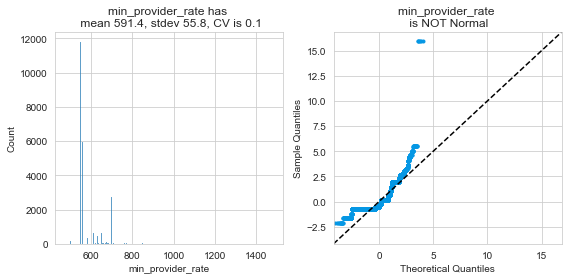

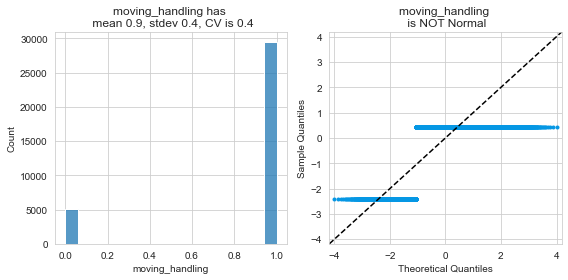

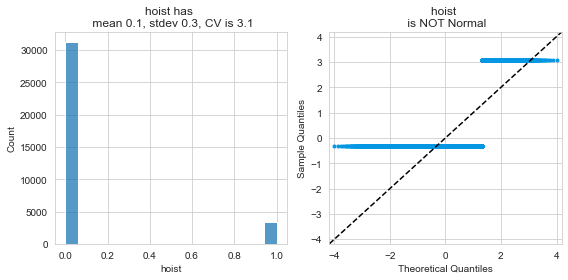

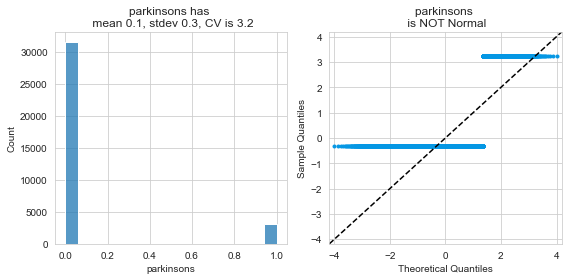

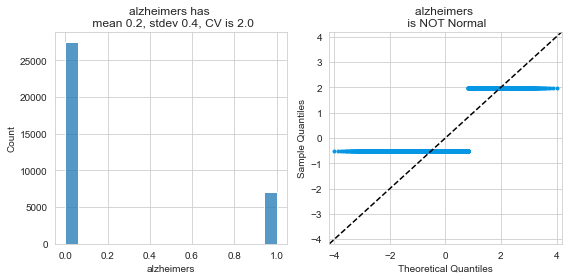

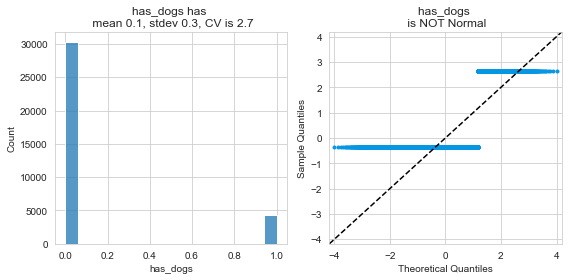

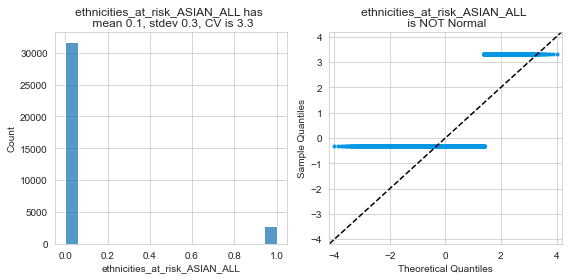

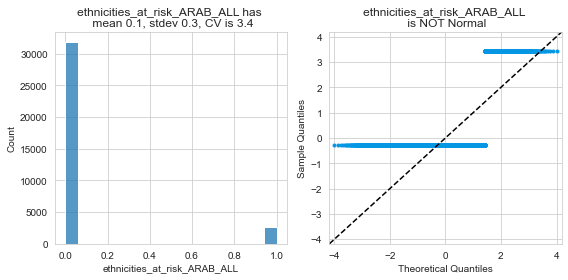

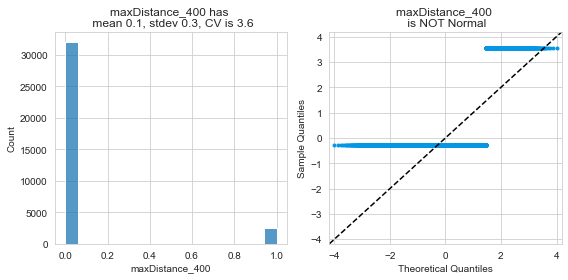

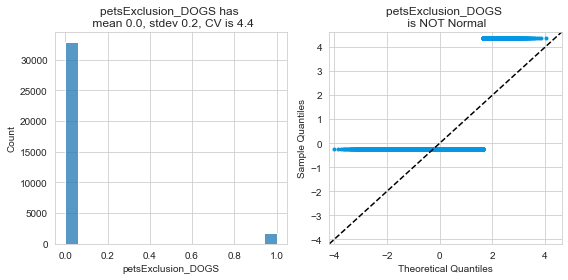

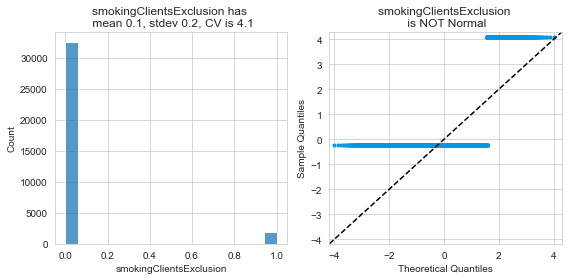

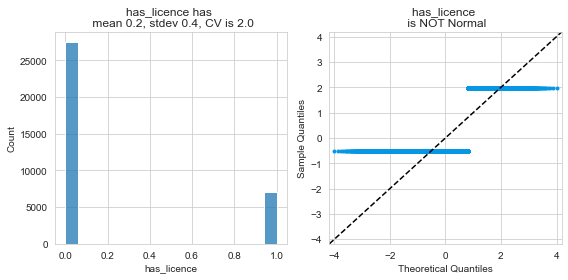

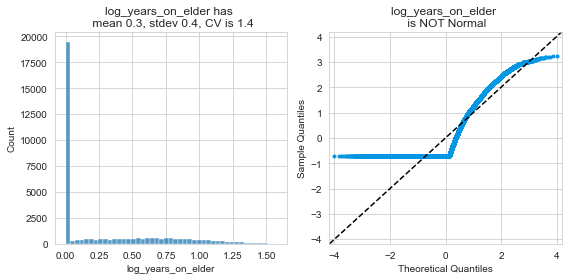

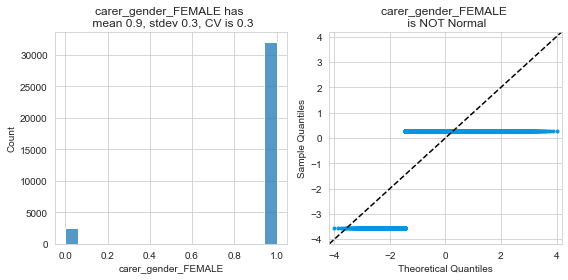

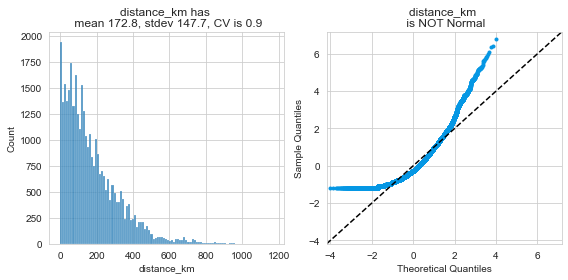

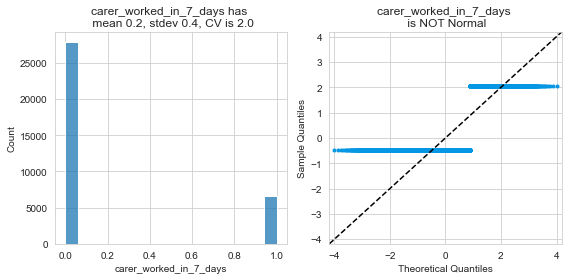

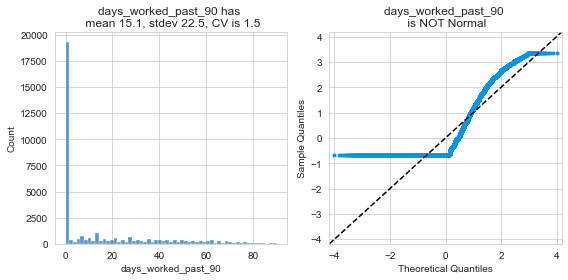

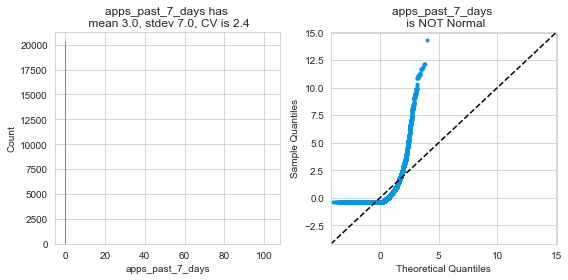

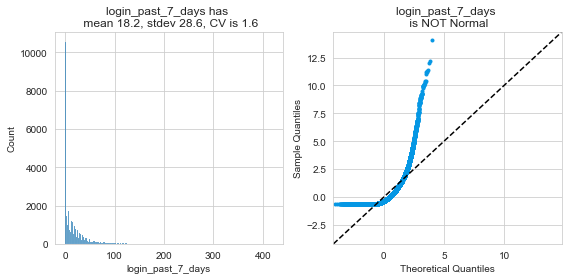

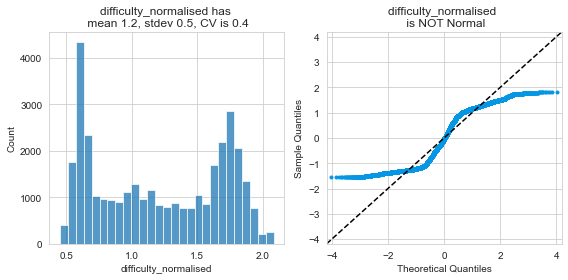

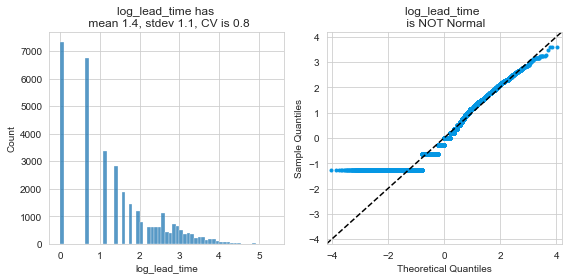

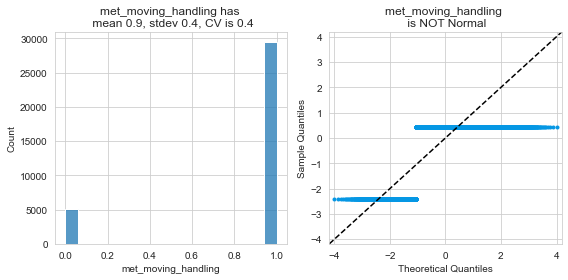

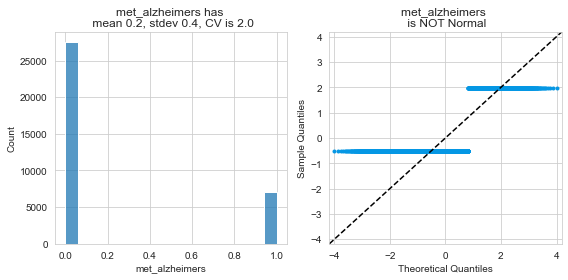

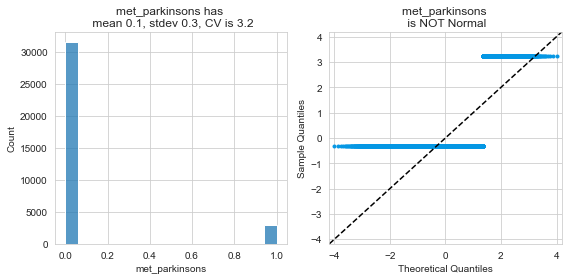

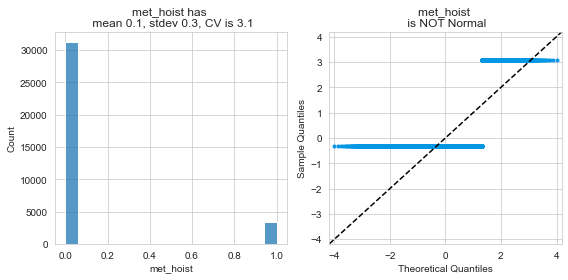

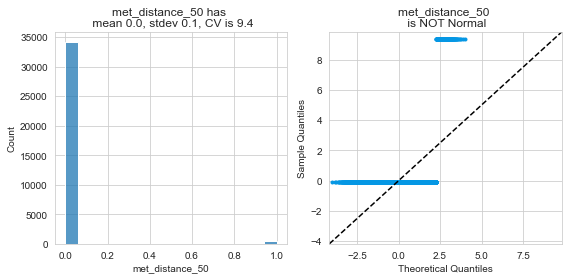

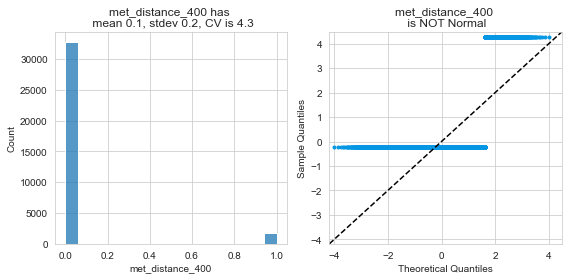

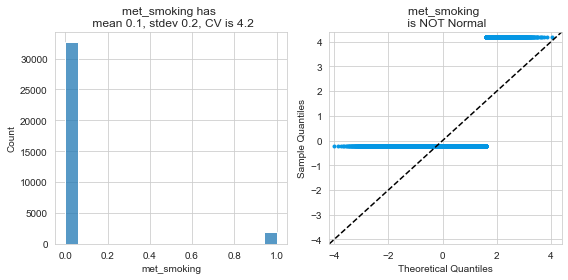

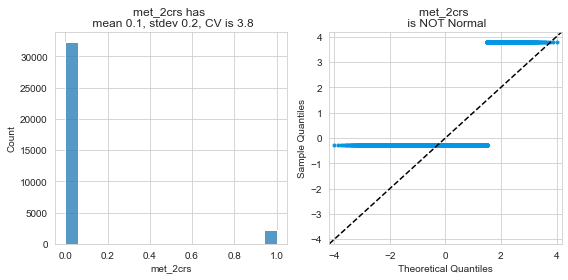

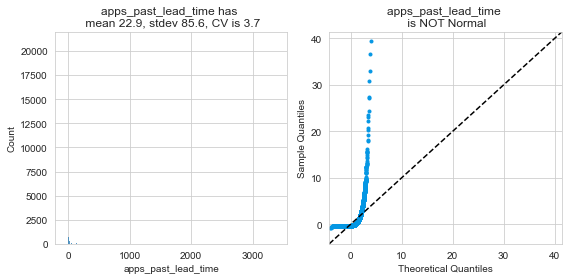

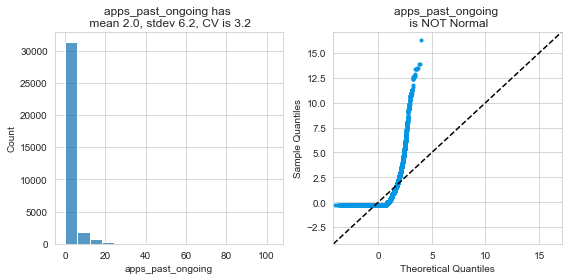

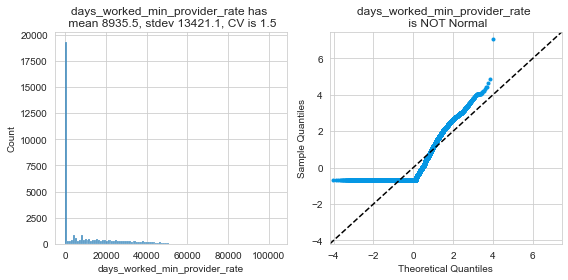

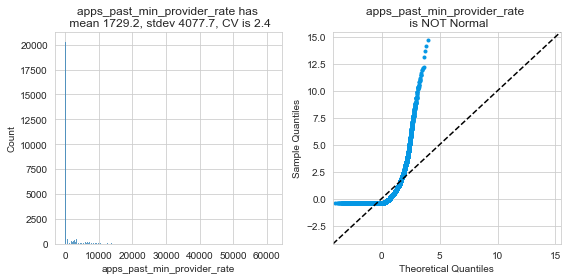

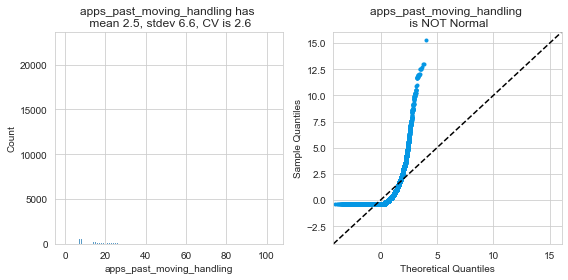

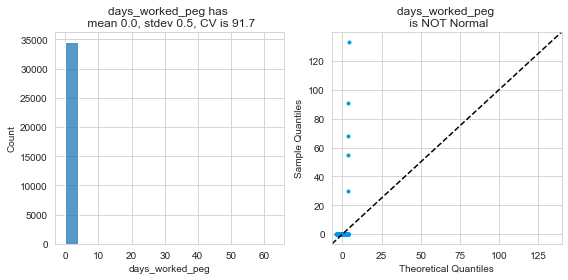

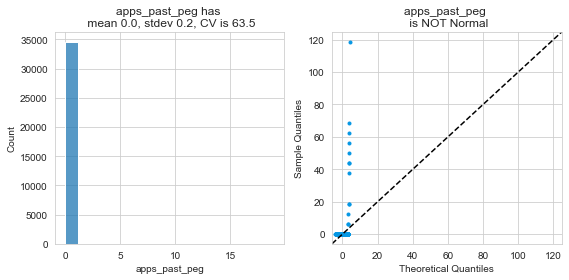

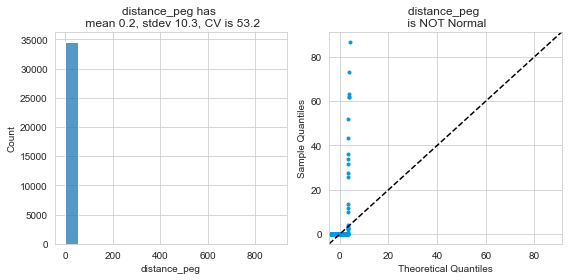

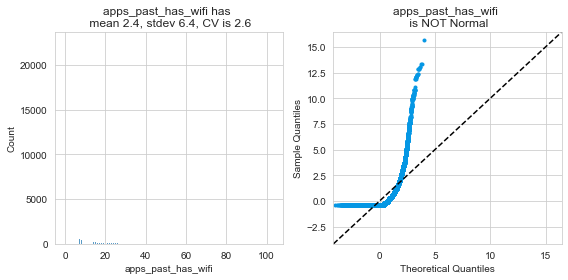

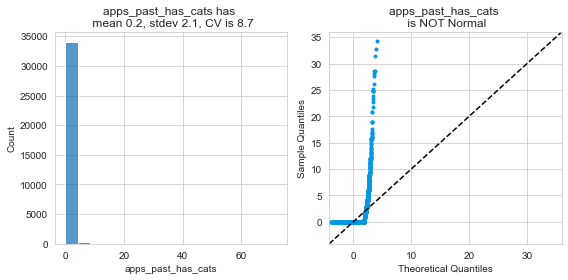

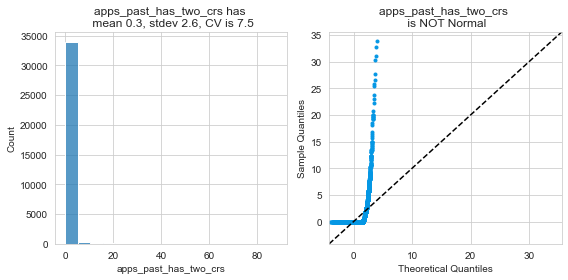

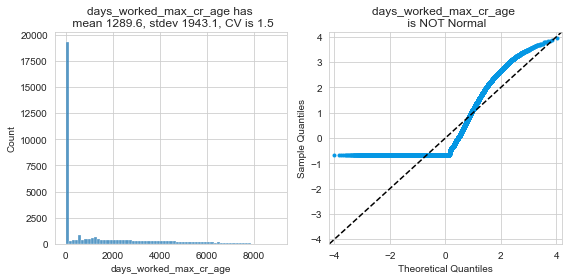

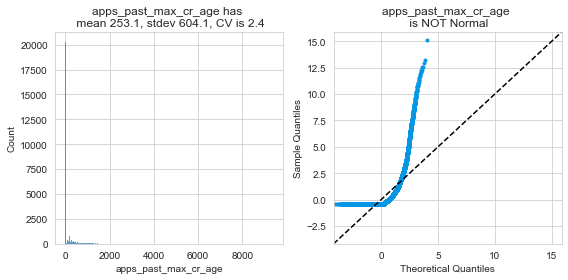

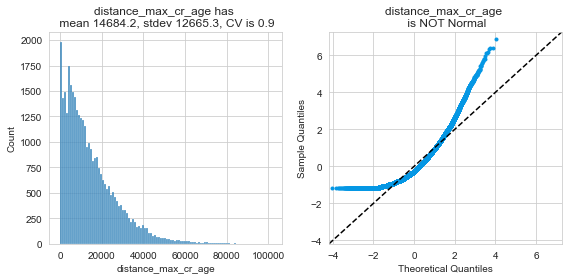

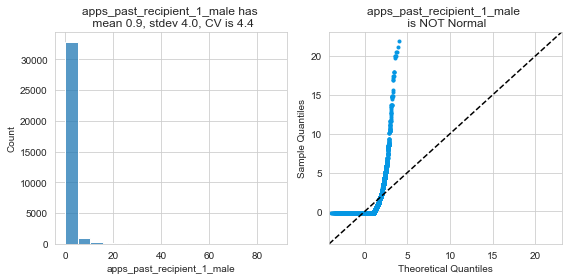

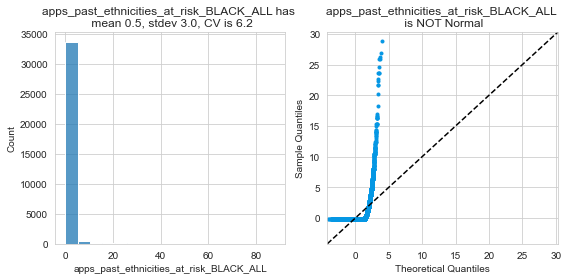

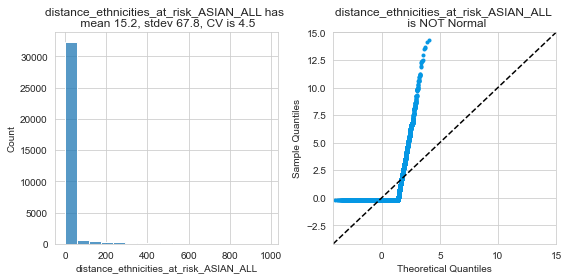

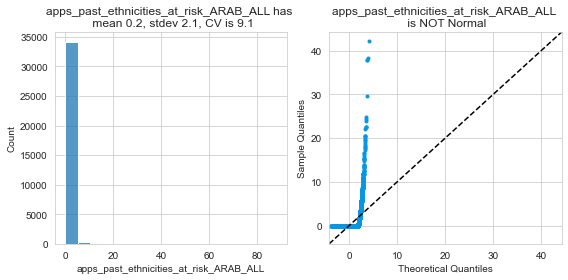

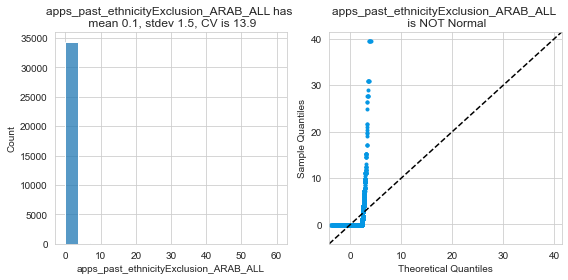

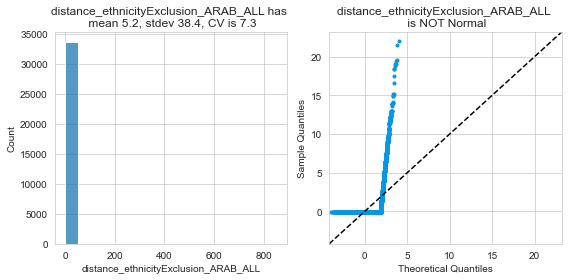

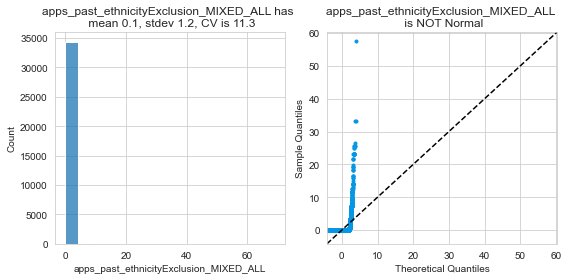

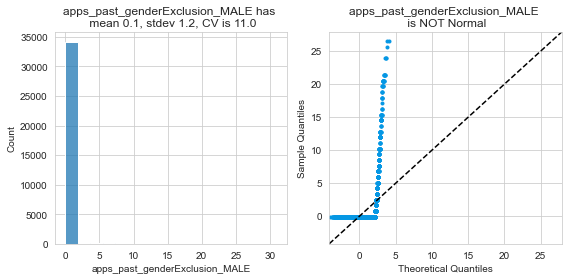

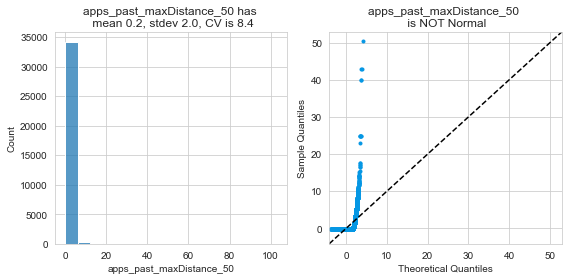

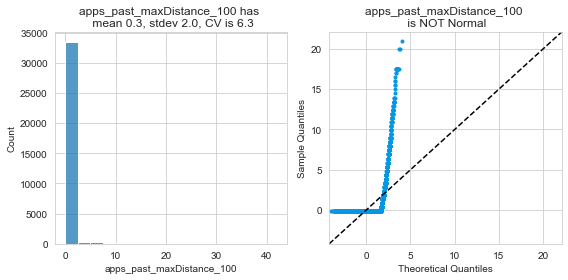

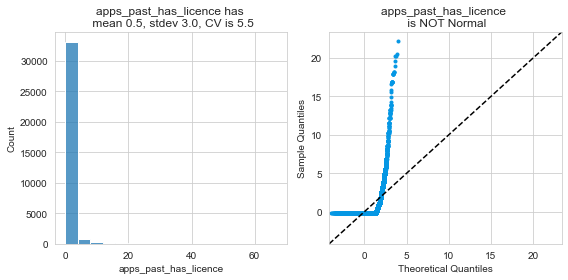

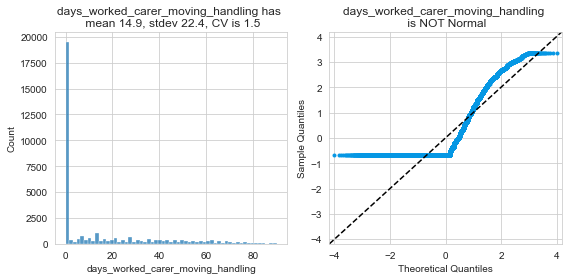

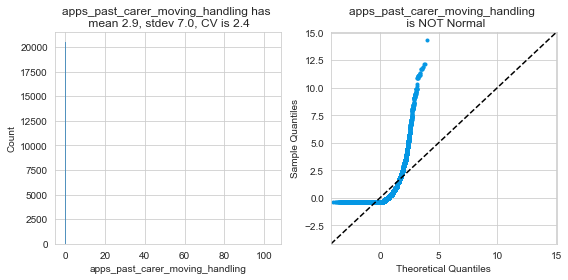

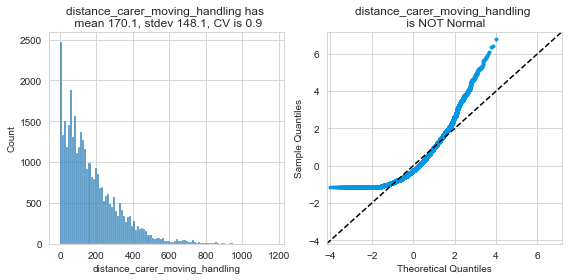

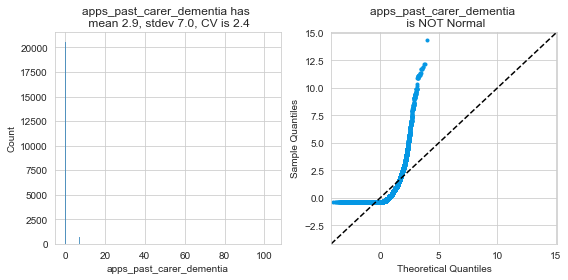

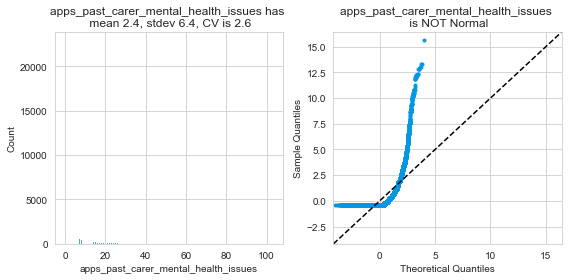

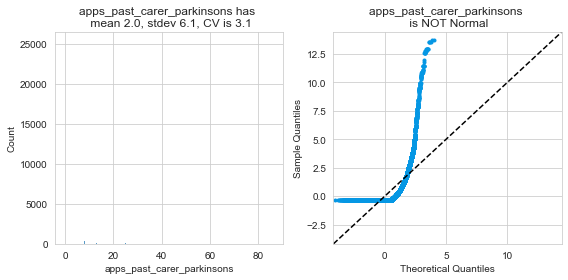

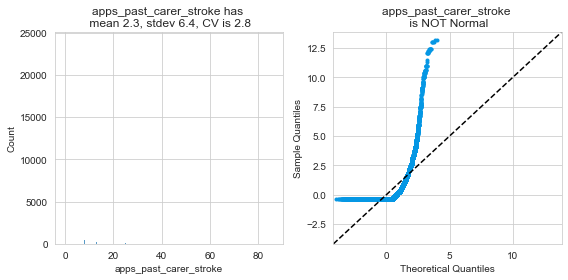

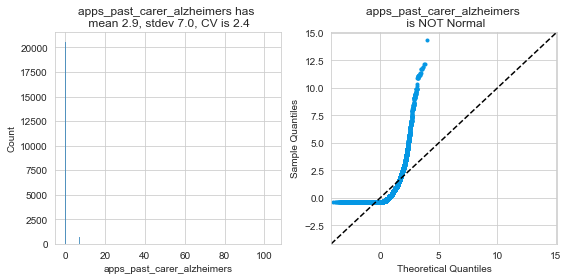

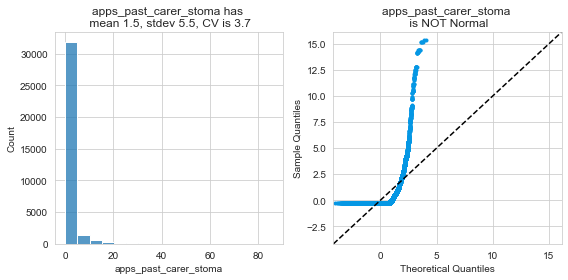

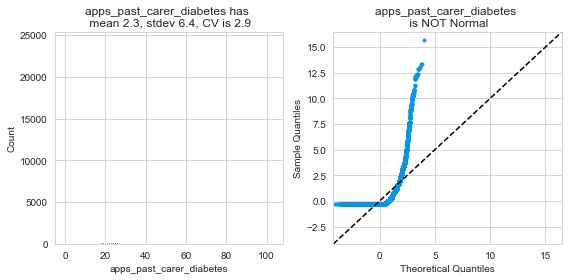

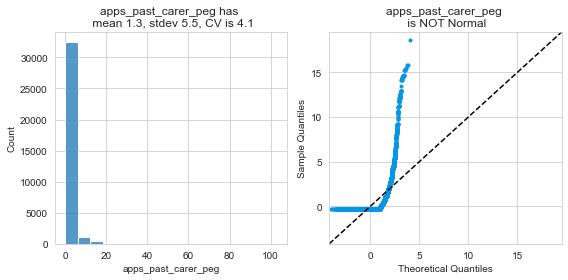

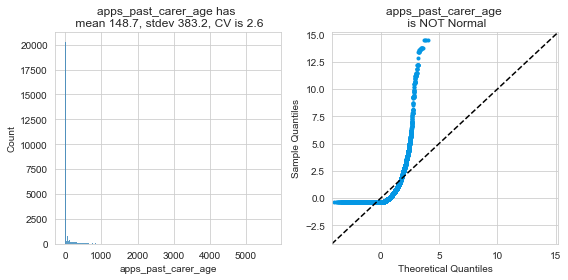

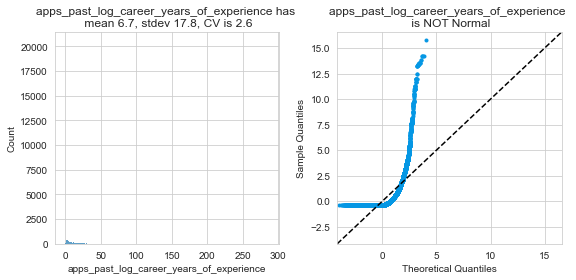

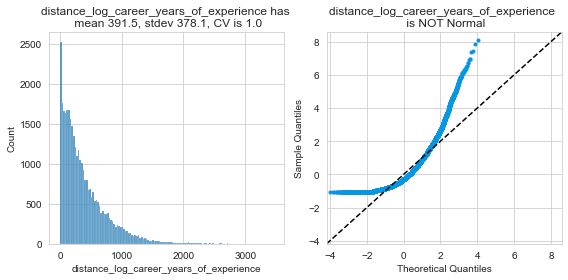

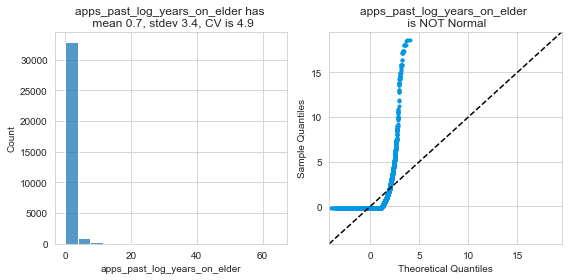

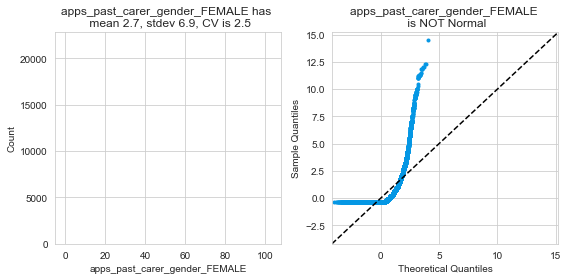

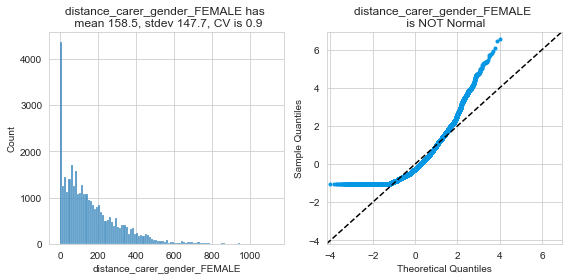

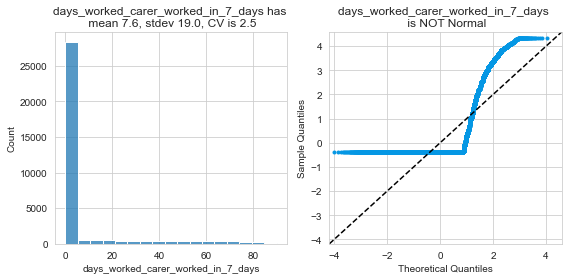

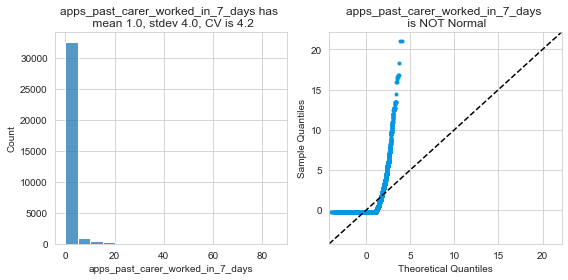

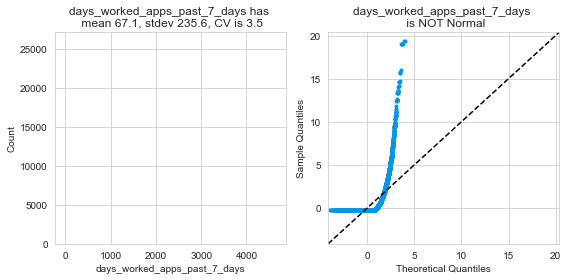

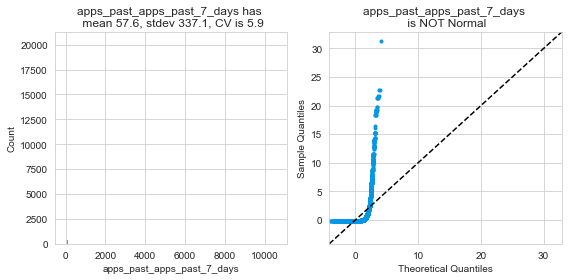

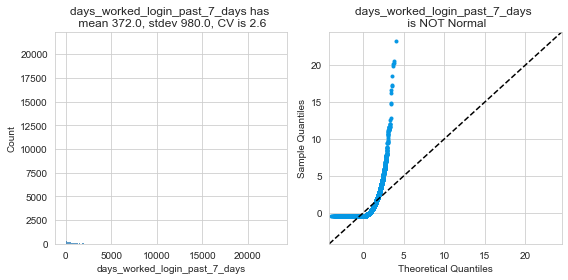

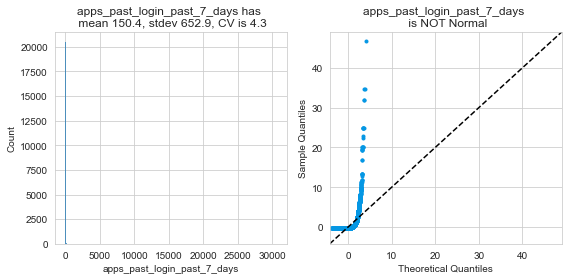

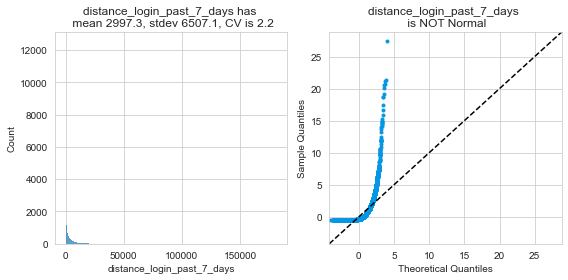

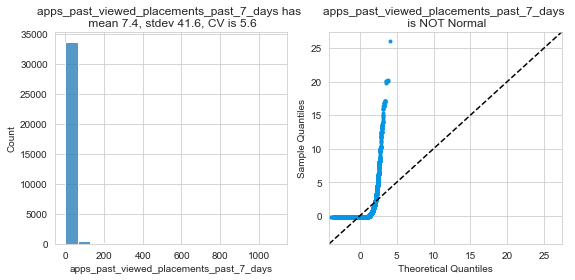

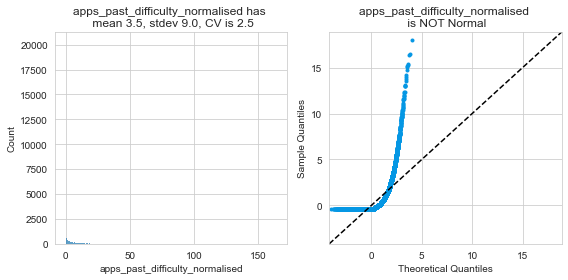

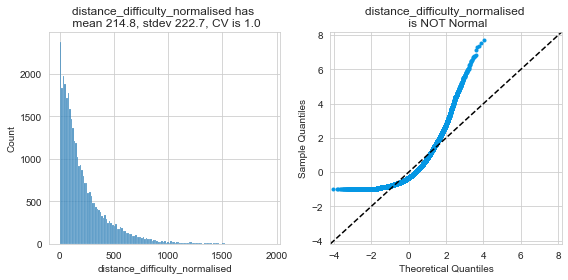

In [395]:
for f in f_predictors:
    plot_histogram(f, df)

<AxesSubplot:>

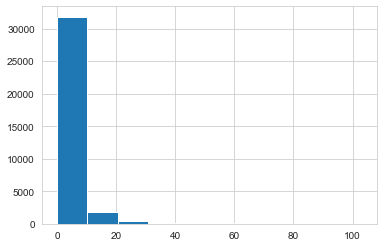

In [397]:
df['apps_past_7_days'].hist()

In [321]:
df.groupby('carer_gender_FEMALE')['carer_id'].count()

carer_gender_FEMALE
0.0      8575
1.0    192408
Name: carer_id, dtype: int64

In [320]:
df.groupby('carer_gender_FEMALE')['carer_id'].nunique()

carer_gender_FEMALE
0.0     607
1.0    3814
Name: carer_id, dtype: int64

We care more about recall than precision for two reasons:

 - conversion apps/messages is less important than apps/placements
 - reaching relevant carers could increase apps/placements and carer 'engagement'

On a balanced sample (around 50% each applied/not applied), the model
['predicted_value','days_worked_past_90','apps_past_7_days','carer_gender_FEMALE'] does a fair job at classifying positive examples
correctly, showing an accuracy of 77.7% together with i) a recall score of 62.7%
and ii) a precision of 81% on the evaluation set (not used for FS)

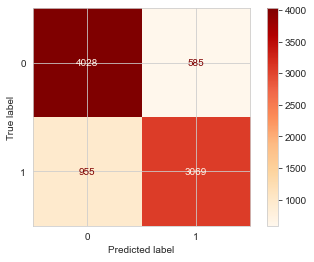

In [445]:
plot_confusion_matrix(model,X_eval[ff_predictors],y_eval, cmap = 'OrRd')

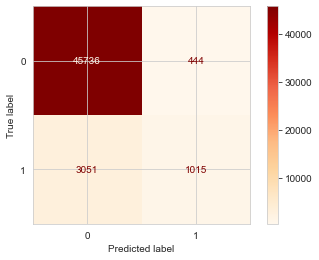

In [336]:
plot_confusion_matrix(model,X_eval[f_predictors],y_eval, cmap = 'OrRd')


  0%|          | 0/1000 [00:00<?, ?it/s]

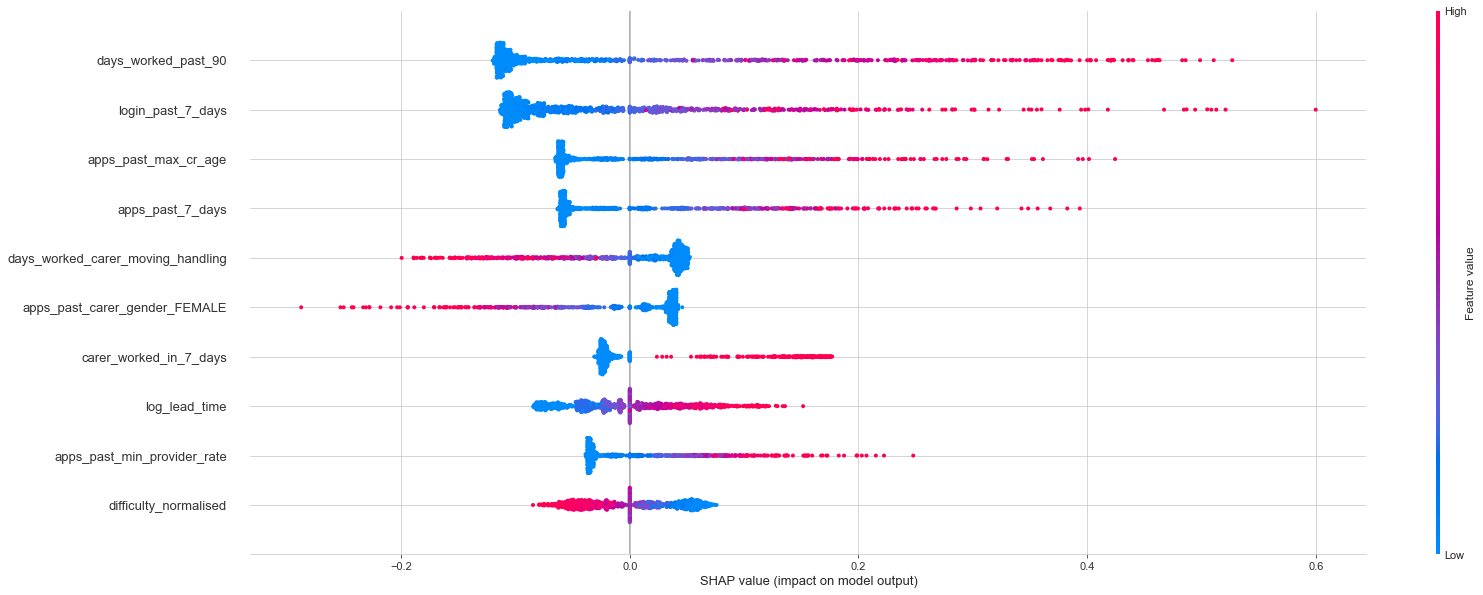

In [390]:
import warnings
warnings.filterwarnings('ignore')


scaler = StandardScaler()
scaler.fit(X_train[ff_predictors])

masker = shap.maskers.Impute(data=scaler.transform(X_train[ff_predictors]), )

model = LogisticRegression()
model.fit(X_eval[ff_predictors],np.ravel(y_eval))

def model_predict_proba(x):
    return model.predict_proba(x)[:,1] #only returning probability of class 1

explainer = shap.KernelExplainer(model_predict_proba, X_train[ff_predictors][:250], masker=masker)
shap_values = explainer.shap_values(X_eval[ff_predictors][:1000])
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
plt.subplot(1, 1, 1)
shap.summary_plot(shap_values, X_eval[ff_predictors][:1000], max_display=10, show=False, plot_size=None )


In [ ]:
plot_shap_metrics(model,df,f_predictors,target)

## Testing login chance

In [3]:
login_events_data = pd.read_csv('../data/login_events_data_10pct.csv')
login_events_data.head()

,date,carer_id,months_from_activation,logged_in
0,2021-06-03,p29021530,26.1667,0
1,2021-02-14,p126398384,29.9333,0
2,2020-05-25,p122373831,27.0667,1
3,2019-12-04,p143916130,8.1000,0
4,2020-10-03,p207985511,2.9333,1


In [7]:
login_events_data['date'] =  login_events_data['date'].apply(lambda x:str(x))


print(login_events_data.shape)
login_training = login_events_data.merge(days_worked_data, how='left', on = ['date','carer_id'])
print(login_training.shape)
login_training = login_training.merge(logs_done_data, how='left', on = ['date','carer_id'])
print(login_training.shape)
login_training = login_training.merge(texts_received_data, how='left', on = ['date','carer_id'])
print(login_training.shape)
login_training = login_training.merge(apps_done_data, how='left', on = ['date','carer_id'])
print(login_training.shape)

login_training.head()

(501404, 4)
(501404, 5)
(501404, 6)
(501404, 7)
(501404, 8)


,date,carer_id,months_from_activation,logged_in,days_worked_past_90,login_past_7_days,texts_past_30_days,apps_past_7_days
0,2021-06-03,p29021530,26.1667,0,NaN,NaN,NaN,NaN
1,2021-02-14,p126398384,29.9333,0,NaN,NaN,NaN,NaN
2,2020-05-25,p122373831,27.0667,1,63.0,49.0,20.0,9.0
3,2019-12-04,p143916130,8.1000,0,NaN,NaN,36.0,NaN
4,2020-10-03,p207985511,2.9333,1,29.0,13.0,28.0,NaN


In [8]:
login_training['texts_past_30_days'].replace(np.nan,0,inplace = True)
login_training['login_past_7_days'].replace(np.nan,0,inplace = True)
login_training['apps_past_7_days'].replace(np.nan,0,inplace = True)
login_training['days_worked_past_90'].replace(np.nan,0,inplace = True)


In [13]:
predictors = login_training.columns.tolist()

[predictors.remove(x) for x in ['date','carer_id','logged_in'] if x in login_training.columns]
target = 'logged_in'

In [50]:
f_predictors = ['months_from_activation',
                'days_worked_past_90',
                'login_past_7_days',
                'texts_past_30_days'
                ]
print(f_predictors)

['months_from_activation', 'days_worked_past_90', 'login_past_7_days', 'texts_past_30_days']


Using 250 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1000 [00:00<?, ?it/s]

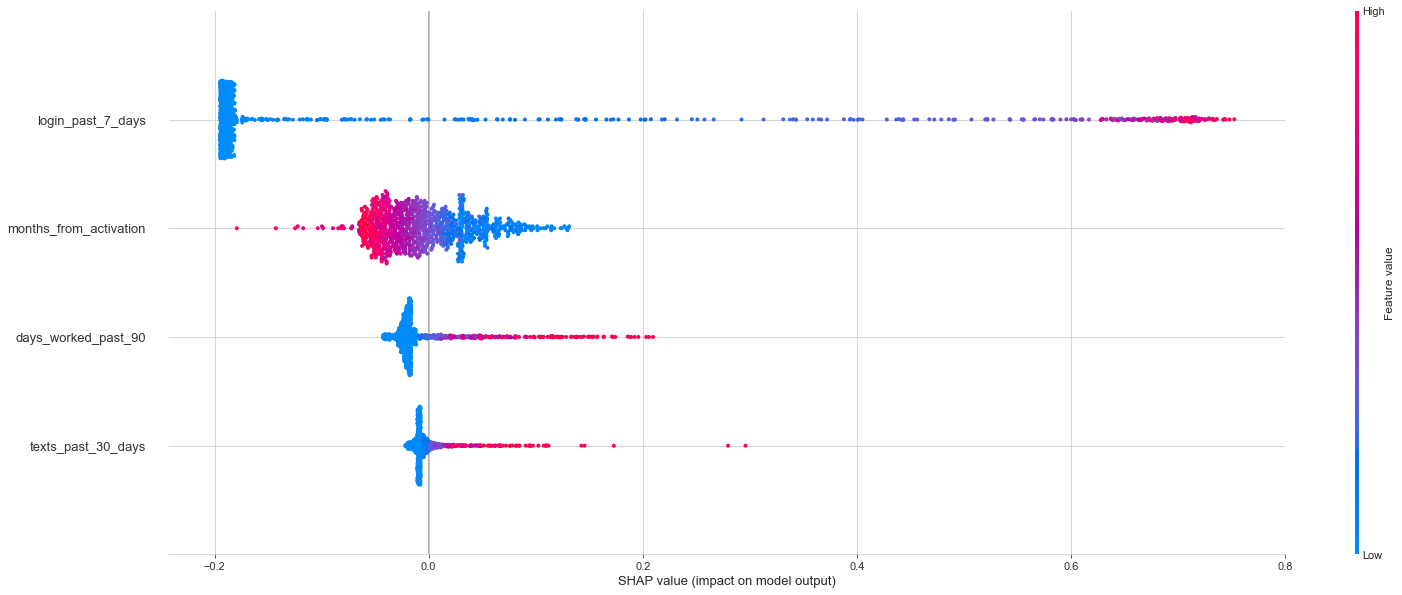

In [51]:
X_train, X_eval, y_train, y_eval = split_train_test(login_training,f_predictors,target, test_size=0.3)

scaler = StandardScaler()
scaler.fit(X_train[f_predictors])

X_train = pd.DataFrame(scaler.transform(X_train[f_predictors]), index=X_train.index, columns=X_train.columns)
X_eval = pd.DataFrame(scaler.transform(X_eval[f_predictors]), index=X_eval.index, columns=X_eval.columns)

masker = shap.maskers.Impute(data=X_train)

model = LogisticRegression()
model.fit(X_train,np.ravel(y_train))

def model_predict_proba(x):
    return model.predict_proba(x)[:,1] #only returning probability of class 1

explainer = shap.KernelExplainer(model_predict_proba,
                                 X_train[:250],
                                 # shap.kmeans(scaler.transform(X_eval[f_predictors]),10),
                                 masker=masker)

shap_values = explainer.shap_values(X_eval[:1000])
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
plt.subplot(1, 1, 1)
shap.summary_plot(shap_values, X_eval[:1000], max_display=10, show=False, plot_size=None )



In [44]:
preds = model.predict(X_eval[f_predictors])
print(f'Recall is {round(recall_score(y_eval,preds),5)}, accuracy is {round(accuracy_score(y_eval,preds),5)}, precision is {round(precision_score(y_eval,preds),5)}')


Recall is 0.76079, accuracy is 0.9155, precision is 0.90749


In [20]:
X_eval.sample(1000, random_state=1992)

,months_from_activation,days_worked_past_90,login_past_7_days,texts_past_30_days,apps_past_7_days
349699,24.5333,0.0,0.0,0.0,0.0
303761,42.1000,0.0,0.0,0.0,0.0
443524,48.9333,0.0,0.0,0.0,0.0
484992,20.8000,22.0,12.0,26.0,0.0
461917,28.6000,0.0,0.0,0.0,0.0
...,...,...,...,...,...
400466,20.6333,0.0,30.0,195.0,0.0
128642,18.5667,0.0,0.0,114.0,0.0
394277,40.9000,17.0,9.0,34.0,7.0
220782,1.9667,31.0,10.0,96.0,0.0


In [75]:
login_events_data.date.max()

'2021-08-17'